**Architecture **

<img src="http://drive.google.com/uc?export=view&id=12JomC2IswVbNGdE0IIvPpUk8vPjP-MBQ"  alt="artchtecture">


---



(1) Importing dependency

In [1]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import os

import numpy as np
np.random.seed(13)
import random
random.seed()

import matplotlib.pyplot as plt
% matplotlib inline

# import gc
# gc.disable()

Using TensorFlow backend.


(2) Get Data

In [2]:
base_data_path = '/data/private/SU/bbchip13/brains_on_beats/magnatagatune/'

### Make Y data
annotations_filename = base_data_path+'annotations_final_top_50_ver_1.csv'
df = pd.read_csv(annotations_filename)
y_names = df.columns[2:]
y_dict = {info[1][0]:info[1][2:].values.astype(np.int32) for info in df.iterrows()}
# y_dict

In [3]:
base_wav_path = base_data_path+'split_wav/'
train_dir = base_wav_path+'train/'
val_dir = base_wav_path+'val/'
test_dir = base_wav_path+'test/'

In [4]:
def crop_random_5sec(filename):
    crop_range = 24
    offset = np.random.randint(crop_range)
    wav_5sec, sr = librosa.load(filename, offset=offset, duration=6, sr=16000)
    wav_5sec = np.expand_dims(wav_5sec, axis=1)
    return wav_5sec

def load_wavs_and_crop(filenames):
    return np.asarray([crop_random_5sec(filename) for filename in tqdm(filenames)])
    
def find_y_by_filename(filename, y_dict):
    basename = os.path.basename(filename)
    name = os.path.splitext(basename)[0]
    y = y_dict[int(name)]
    return y

def make_y_by_filenames(filenames, y_dict):
    return np.asarray([find_y_by_filename(filename, y_dict) 
                           for filename in filenames])

def make_train_data(filenames, y_dict):
    x_train = load_wavs_and_crop(filenames)
    y_train = make_y_by_filenames(filenames, y_dict)
    return x_train, y_train

In [4]:
print('Make train data.......')
x_train_wav_filenames = [train_dir+filename for filename in os.listdir(train_dir)
                            if filename.endswith('.wav')]#[:1000]
x_train, y_train = make_train_data(x_train_wav_filenames, y_dict)

print('Make validation data.......')
x_val_wav_filenames = [val_dir+filename for filename in os.listdir(val_dir)
                            if filename.endswith('.wav')]#[:200]
x_val, y_val = make_train_data(x_val_wav_filenames, y_dict)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

Make train data.......



Make validation data.......



(18706, 96000, 1) (18706, 50) (1825, 96000, 1) (1825, 50)


(3) Create a sequential model

In [5]:
### Define Parametric Softplus

# alpha * log(1 + exp(beta * x))
def ParametricSoftplus(alpha=0.2, beta=5.0):
  return lambda x: alpha * keras.activations.softplus(beta * x)

In [6]:
model=Sequential()

# 1st Convolutional Layer (conv1)
model.add(Conv1D (kernel_size=121, filters=48, strides=16, padding='same',
#                   input_shape=x_train.shape[1:]))                  
                  input_shape=(96000, 1)))

model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(BatchNormalization())

# Pooling (pool1)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 2nd Convolutional Layer (conv2)
model.add(Conv1D (kernel_size=25, filters=128, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(BatchNormalization())

# Pooling (pool2)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 3rd Convolutional Layer (conv3)
model.add(Conv1D (kernel_size=9, filters=192, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# 4rd Convolutional Layer (conv4)
model.add(Conv1D (kernel_size=9, filters=192, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# 5rd Convolutional Layer (conv5)
model.add(Conv1D (kernel_size=9, filters=128, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# Pooling (pool5)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 1st Dense Layer (full6)
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(Dropout(0.5)) # Drop-out value is not specified in the paper

# 2nd Dense Layer (full7)
model.add(Dense(4096))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(Dropout(0.5))

# Output Layer (full8)
model.add(Dense(50))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6000, 48)          5856      
_________________________________________________________________
activation_1 (Activation)    (None, 6000, 48)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6000, 48)          192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1500, 48)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1500, 128)         153728    
_________________________________________________________________
activation_2 (Activation)    (None, 1500, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1500, 128)         512       
__________

(4) Compile 

In [7]:
adam_with_params = keras.optimizers.Adam(lr=0.0002, beta_1=0.1, beta_2=0.999, 
                                         epsilon=1e-8)
model.compile(loss='binary_crossentropy', optimizer=adam_with_params,
              metrics=['accuracy'])

(5) Train

In [8]:
model_path = 'check_point/'
os.makedirs(model_path, exist_ok=True)
model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", verbose=1, save_best_only=True)

In [8]:
model.fit(x_train, y_train, batch_size=36, epochs=100, validation_data=[x_val, y_val], shuffle=True, callbacks = [checkpointer])

Train on 18706 samples, validate on 1825 samples
Epoch 1/100
18706/18706 [==============================] - 60s 3ms/step - loss: 0.2057 - acc: 0.9446 - val_loss: 0.1946 - val_acc: 0.9446

Epoch 00001: val_loss improved from inf to 0.19460, saving model to check_point/01-0.1946.hdf5
Epoch 2/100
18706/18706 [==============================] - 53s 3ms/step - loss: 0.1858 - acc: 0.9459 - val_loss: 0.1820 - val_acc: 0.9446

Epoch 00002: val_loss improved from 0.19460 to 0.18203, saving model to check_point/02-0.1820.hdf5
Epoch 3/100
18706/18706 [==============================] - 53s 3ms/step - loss: 0.1826 - acc: 0.9458 - val_loss: 0.1824 - val_acc: 0.9430

Epoch 00003: val_loss did not improve from 0.18203
Epoch 4/100
18706/18706 [==============================] - 53s 3ms/step - loss: 0.1817 - acc: 0.9459 - val_loss: 0.1821 - val_acc: 0.9446

Epoch 00004: val_loss did not improve from 0.18203
Epoch 5/100
18706/18706 [==============================] - 54s 3ms/step - loss: 0.1807 - acc: 0.945

18706/18706 [==============================] - 54s 3ms/step - loss: 0.1082 - acc: 0.9592 - val_loss: 0.1823 - val_acc: 0.9445

Epoch 00039: val_loss did not improve from 0.15718
Epoch 40/100
18706/18706 [==============================] - 54s 3ms/step - loss: 0.1029 - acc: 0.9610 - val_loss: 0.1837 - val_acc: 0.9451

Epoch 00040: val_loss did not improve from 0.15718
Epoch 41/100
18706/18706 [==============================] - 54s 3ms/step - loss: 0.0980 - acc: 0.9628 - val_loss: 0.1918 - val_acc: 0.9439

Epoch 00041: val_loss did not improve from 0.15718
Epoch 42/100
18706/18706 [==============================] - 54s 3ms/step - loss: 0.0927 - acc: 0.9644 - val_loss: 0.1971 - val_acc: 0.9425

Epoch 00042: val_loss did not improve from 0.15718
Epoch 43/100
18706/18706 [==============================] - 54s 3ms/step - loss: 0.0878 - acc: 0.9662 - val_loss: 0.2012 - val_acc: 0.9426

Epoch 00043: val_loss did not improve from 0.15718
Epoch 44/100
18706/18706 [==============================] 

18706/18706 [==============================] - 54s 3ms/step - loss: 0.0131 - acc: 0.9954 - val_loss: 0.3374 - val_acc: 0.9382

Epoch 00082: val_loss did not improve from 0.15718
Epoch 83/100
18706/18706 [==============================] - 54s 3ms/step - loss: 0.0127 - acc: 0.9955 - val_loss: 0.3496 - val_acc: 0.9376

Epoch 00083: val_loss did not improve from 0.15718
Epoch 84/100
18706/18706 [==============================] - 54s 3ms/step - loss: 0.0127 - acc: 0.9955 - val_loss: 0.3281 - val_acc: 0.9375

Epoch 00084: val_loss did not improve from 0.15718
Epoch 85/100
18706/18706 [==============================] - 54s 3ms/step - loss: 0.0119 - acc: 0.9959 - val_loss: 0.3508 - val_acc: 0.9374

Epoch 00085: val_loss did not improve from 0.15718
Epoch 86/100
18706/18706 [==============================] - 54s 3ms/step - loss: 0.0115 - acc: 0.9960 - val_loss: 0.3413 - val_acc: 0.9375

Epoch 00086: val_loss did not improve from 0.15718
Epoch 87/100
18706/18706 [==============================] 

(6) Test

In [9]:
def make_patch_data(wav, sr, i):
    patch_data = wav[i*sr:(i+6)*sr]
    patch_data = np.expand_dims(patch_data, axis=1)
    return patch_data

def make_patch_by_filename(filename):
    wav, sr = librosa.load(filename, sr=16000)
    patch_range = 24
    patch_list = [make_patch_data(wav, sr, i) for i in range(patch_range)]
    return np.asarray([patch_list])

def load_test_wavs(filenames):
    patch_arr = np.asarray([make_patch_by_filename(filename) for filename in tqdm(filenames)])
    result_arr = patch_arr.reshape(-1, *patch_arr.shape[-2:])
    return result_arr
#    return np.concatenate(patch_list, axis=None)

def make_test_data(filenames, y_dict):
    x_test = load_test_wavs(filenames)
    repeat_size = x_test.shape[0] / len(filenames)
    y_test = np.repeat(make_y_by_filenames(filenames, y_dict), repeat_size, axis=0)
    return x_test, y_test

In [10]:
print('Make test data.......')
x_test_wav_filenames = [test_dir+filename for filename in os.listdir(test_dir)
                            if filename.endswith('.wav')]
x_test_wav_filenames = random.sample(x_test_wav_filenames, 500)
x_test, y_test = make_test_data(x_test_wav_filenames, y_dict)

print(x_test.shape, y_test.shape)

Make test data.......


NameError: name 'random' is not defined

In [21]:
model = load_model(model_path+'28-0.1572.hdf5',custom_objects={'<lambda>': ParametricSoftplus(0.2, 0.5)})

In [22]:
[loss, accuracy] = model.evaluate(x_test, y_test)
print('Loss:', loss, 'Accuracy:', accuracy)

12000/12000 [==============================] - 12s 965us/step
Loss: 0.15250972924629846 Accuracy: 0.9502833369572957


In [44]:
def sort_list(list1, list2): 
    pairs = zip(list2, list1)
    result = [(x, y) for y, x in sorted(pairs, reverse=True)]
    x_list = [x for x, _ in result]
    y_list = [y for _, y in result]

    return x_list, y_list

In [45]:
pred = model.predict(x_test)
accu_table = (pred > 0.5) == y_test
accu_arr = accu_table.sum(axis=0) / y_test.shape[0]

tag_list, accu_list = sort_list(y_names, accu_arr)
for tag, accu in zip(tag_list, accu_list):
    print(tag, ':', accu)

country : 0.9976666666666667
cello : 0.996
female voice : 0.986
harpsichord : 0.9856666666666667
classic : 0.984
choral : 0.9820833333333333
voice : 0.98
no voice : 0.98
male voice : 0.978
female vocal : 0.978
beats : 0.9759166666666667
solo : 0.974
choir : 0.9729166666666667
weird : 0.972
metal : 0.9703333333333334
male vocal : 0.97025
violin : 0.9695
woman : 0.968
man : 0.9678333333333333
male : 0.9678333333333333
sitar : 0.96325
dance : 0.96275
opera : 0.96225
vocals : 0.96
loud : 0.95975
indian : 0.9594166666666667
rock : 0.9590833333333333
singing : 0.958
pop : 0.956
no vocal : 0.956
soft : 0.952
new age : 0.952
harp : 0.948
flute : 0.94625
no vocals : 0.946
beat : 0.9454166666666667
female : 0.9439166666666666
quiet : 0.9405
vocal : 0.9379166666666666
drums : 0.9370833333333334
piano : 0.9350833333333334
synth : 0.934
fast : 0.9263333333333333
strings : 0.9260833333333334
techno : 0.9215
electronic : 0.9075833333333333
classical : 0.9046666666666666
guitar : 0.8373333333333334
am

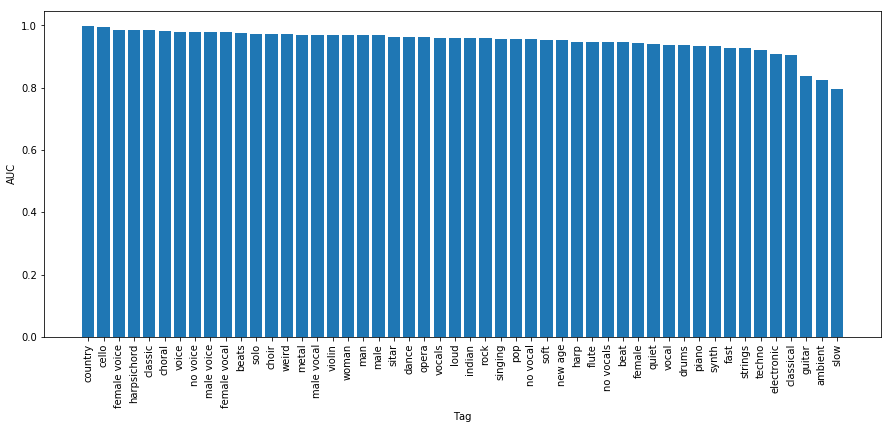

In [48]:
plt.figure(figsize = (15, 6))
x = np.arange(len(accu_list))
plt.bar(x, accu_list)
plt.xticks(x, tag_list, rotation='vertical')
plt.xlabel('Tag') # , fontsize=18)
plt.ylabel('AUC') # , fontsize=16)

plt.show()

In [57]:
pred = model.predict(x_test)
true_positive = (pred > 0.5) & y_test
precision_arr = true_positive.sum(axis=0) / (pred.sum(axis=0) + keras.backend.epsilon())

tag_list, precision_list = sort_list(y_names, precision_arr)
for tag, accu in zip(tag_list, precision_list):
    print(tag, ':', accu)

rock : 0.739828054859531
techno : 0.5386532210261222
choir : 0.3290040688224287
loud : 0.32035088183497007
metal : 0.2243854462810687
choral : 0.14588498941574143
dance : 0.14499968854530917
guitar : 0.14290257833406078
beat : 0.13589127536790235
classical : 0.1014708340949481
piano : 0.07009329152920685
flute : 0.05510137611154386
opera : 0.05186524378662427
fast : 0.04251383287185809
harpsichord : 0.0246495233658194
ambient : 0.020561898039892893
male : 0.012957800265171224
quiet : 0.0070947762919689825
male vocal : 0.006847943798711246
violin : 0.0050995624411084165
beats : 0.003369809436289129
sitar : 0.0032353880041631135
electronic : 0.0027763857187852047
indian : 0.0020003853281308336
female : 0.0017839190973526157
strings : 0.0011030312961566994
drums : 0.0009519473435532876
woman : 0.0
weird : 0.0
voice : 0.0
vocals : 0.0
vocal : 0.0
synth : 0.0
solo : 0.0
soft : 0.0
slow : 0.0
singing : 0.0
pop : 0.0
no voice : 0.0
no vocals : 0.0
no vocal : 0.0
new age : 0.0
man : 0.0
male v

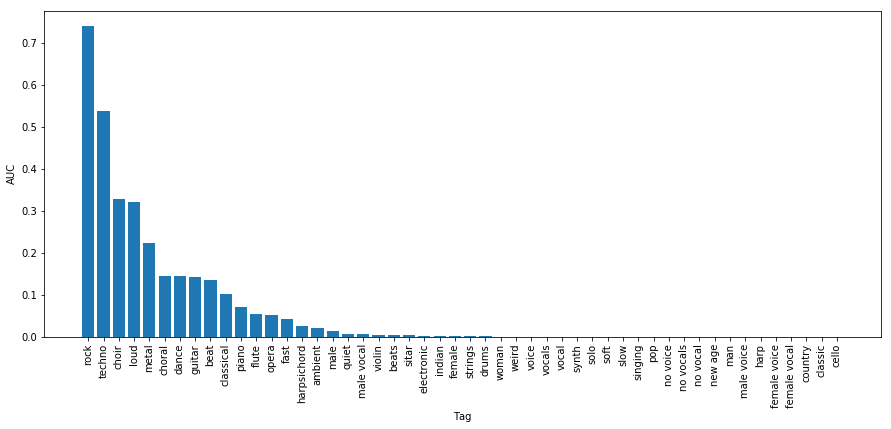

In [58]:
plt.figure(figsize = (15, 6))
x = np.arange(len(precision_list))
plt.bar(x, precision_list)
plt.xticks(x, tag_list, rotation='vertical')
plt.xlabel('Tag') # , fontsize=18)
plt.ylabel('AUC') # , fontsize=16)

plt.show()